## Import necessary Modules  

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch, torchvision
import detectron2

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger() # this logs Detectron2 information such as what the model is doing when it's training

# import some common libraries
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cv2
import random

# import some common detectron2 utilities
from detectron2.structures import BoxMode
from detectron2 import model_zoo # a series of pre-trained Detectron2 models: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md
from detectron2.engine import DefaultPredictor # a default predictor class to make predictions on an image using a trained model
from detectron2.config import get_cfg # a config of "cfg" in Detectron2 is a series of instructions for building a model
from detectron2.utils.visualizer import Visualizer # a class to help visualize Detectron2 predictions on an image
from detectron2.data import MetadataCatalog # stores information about the model such as what the training/test data is, what the class names are

In [ ]:
detectron2.__version__

--2020-08-21 22:27:33--  https://raw.githubusercontent.com/mrdbourke/airbnb-amenity-detection/master/custom_images/airbnb-article-cover.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.152.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.152.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



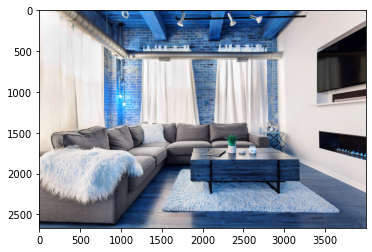

In [4]:
# Download and display example image and save it as demo.jpeg
!wget -c https://raw.githubusercontent.com/mrdbourke/airbnb-amenity-detection/master/custom_images/airbnb-article-cover.jpeg -O demo.jpeg
img = cv2.imread("./demo.jpeg")
plt.imshow(img)

## Data Preparation

### Airnb target classes (the ones which relate most to their business).

In [3]:
# Target classes
target_classes = ["Toilet",
          "Swimming_pool",
          "Bed",
          "Billiard_table",
          "Sink",
          "Fountain",
          "Oven",
          "Ceiling_fan",
          "Television",
          "Microwave_oven",
          "Gas_stove",
          "Refrigerator",
          "Kitchen_&_dining_room_table",
          "Washing_machine",
          "Bathtub",
          "Stairs",
          "Fireplace",
          "Pillow",
          "Mirror",
          "Shower",
          "Couch",
          "Countertop",
          "Coffeemaker",
          "Dishwasher",
          "Sofa_bed",
          "Tree_house",
          "Towel",
          "Porch",
          "Wine_rack",
          "Jacuzzi"]

### Pre-trained Model (Test)

In [4]:
# Change Dirrectory to DataSets directory
import os
if 'DataSets' not in os.getcwd():
    os.chdir('DataSets')
os.getcwd()

'/home/santhosh/HardDisk/skumar/DataScience/Projects_Section/Projects_Working/Airbnb_Amenity_Detection/DataSets'

In [16]:
# Setup a model config file (set of instructions for the model)
cfg = get_cfg() # setup a default config, see: https://detectron2.readthedocs.io/modules/config.html
cfg.merge_from_file("../retinanet_model_final_config.yaml") # merge the config YAML file (a set of instructions on how to build a model)
cfg.MODEL.WEIGHTS = "../retinanet_model_final.pth" # setup the model weights from the fully trained model


# Create a default Detectron2 predictor for making inference
predictor = DefaultPredictor(cfg)

# Make a prediction the example image from above
#outputs = predictor(img)

NameError: name 'DefaultPredictor' is not defined

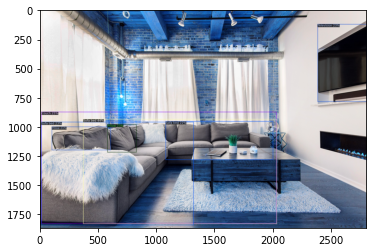

In [19]:
# Number of predicted amenities to draw on the target image
num_amenities = 7

# Set up a visulaizer instance: https://detectron2.readthedocs.io/modules/utils.html#detectron2.utils.visualizer.Visualizer
visualizer = Visualizer(img_rgb=img[:, :, ::-1], # we have to reverse the color order otherwise we'll get blue images (BGR -> RGB)
                        metadata=MetadataCatalog.get(cfg.DATASETS.TEST[0]).set(thing_classes=target_classes), # we tell the visualizer what classes we're drawing (from the target classes)
                        scale=0.7)

# Draw the models predictions on the target image
visualizer = visualizer.draw_instance_predictions(outputs["instances"][:num_amenities].to("cpu"))

# Display the image
plt.imshow(visualizer.get_image()[:, :, ::-1]);

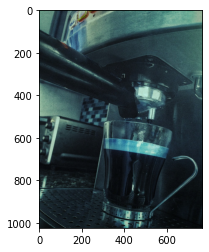

In [18]:
import os
# Read in a random image from the training directory
train_img = cv2.imread("./DataSets/train/" + random.sample(os.listdir("./DataSets/train/"), 1)[0])
plt.imshow(train_img);


### Combine images with labels (preprocess data)

We have to get our images and labels into Detectron2 input style. This means, getting them into a list of dictionaries.

Every image in your dataset set will have one of these. Let's break it down.

- *annotations* (list): all of the annotations (labels) on an image, a single image may have more than one of these. For object detection (our use case), it contains:
    - *bbox* (list of int): the coordinates in pixel values of a bounding box.
    - *bbox_mode* (Enum): the order and scale of the pixel values in bbox, see more in the docs.
     - *category_id* (int): the numerical mapping of the category of the object inside bbox, example {coffeemaker:0, fireplace:1}.
- *file_name* (str): string filepath to target image.
- *height* (int): height of target image.
- *width* (int): width of target image.
- *image_id* (int): unique image identifier, used during evaluation to identify images.

In [9]:
!pwd

/home/santhosh/HardDisk/skumar/DataScience/Projects_Section/Projects_Working/Airbnb_Amenity_Detection


Generate Json file with annotations formatted in way Detectron2 accepts 

In [4]:
from preprocessing import *

In [11]:
get_image_dicts("train_images", "train-annotations-bbox.csv")
get_image_dicts("valid_images", "validation-annotations-bbox.csv")

Using validation-annotations-bbox.csv for annotations...


2it [00:00, 18.16it/s]

On dataset: valid_images
Classes we're using:
 Person            276
Furniture         148
Chair             143
Swimming pool     142
Human hair        133
                 ... 
Sewing machine      1
Snack               1
Frying pan          1
Sports uniform      1
Jeans               1
Name: ClassName, Length: 165, dtype: int64
Total number of images: 741


741it [00:10, 67.86it/s]

Saving labels to: valid_images/valid_images_labels.json...


In [5]:
def get_image_ids(image_folder=None):
    """
    Explores a folder of images and gets their ID from their file name.
    Returns a list of all image ID's in image_folder.
    E.g. image_folder/608fda8c976e0ac.jpg -> ["608fda8c976e0ac"]
    
    Params
    ------
    image_folder (str): path to folder of images, e.g. "../validation/"
    """
    return [os.path.splitext(img_name)[0] for img_name in os.listdir(image_folder) if img_name.endswith(".jpg")]

# Make a function which formats a specific annotations csv based on what we're dealing with
def format_annotations(image_folder, annotation_file, target_classes=None):
    """
    TODO - NOTE: This function could (definitely can) be faster.
    TODO - Some ideas: skip the use of pandas entirely and use CSV's
    
    Formats annotation_file based on images contained in image_folder.
    Will get all unique image IDs and make sure annotation_file
    only contains those (the target images).
    Adds meta-data to annotation_file such as class names and categories.
    If target_classes isn't None, the returned annotations will be filtered by this list.
    Note: image_folder and annotation_file should both be validation if working on
    validation set or both be training if working on training set.
    
    Params
    ------
    image_folder (str): path to folder of target images.
    annotation_file (str): path to annotation file of target images.
    target_classes (list), optional: a list of target classes you'd like to filter labels.
    """
    # Get all image ids from target directory
    image_ids = get_image_ids(image_folder)
    
    # Setup annotation file and classnames
    # TODO - improve this, is pandas required? 
    annot_file = pd.read_csv(annotation_file)
    classes = pd.read_csv("class-descriptions-boxable.csv",
                          names=["LabelName", "ClassName"])
    
    # Create classname column on annotations which converts label codes to string labels
    annot_file["ClassName"] = annot_file["LabelName"].map(classes.set_index("LabelName")["ClassName"])

    # Sort annot_file by "ClassName" for alphabetical labels (used with target_classes)
    annot_file.sort_values(by=["ClassName"], inplace=True)
    
    # TODO - fix this, Make sure we only get the images we're concerned about
    if target_classes:
        annot_file = annot_file[annot_file["ImageID"].isin(image_ids) & annot_file["ClassName"].isin(target_classes)]
    else:
        annot_file = annot_file[annot_file["ImageID"].isin(image_ids)]
   
    # Add ClassID column, e.g. "Bathtub, Toilet" -> 1, 2
    annot_file["ClassName"] = pd.Categorical(annot_file["ClassName"])
    annot_file["ClassID"] = annot_file["ClassName"].cat.codes
    
    return annot_file

def rel_to_absolute(bbox, height, width):
    """
    Converts bounding box dimensions from relative to absolute pixel values (Detectron2 style).
    See: https://detectron2.readthedocs.io/modules/structures.html#detectron2.structures.BoxMode
    
    Params
    ------
    bbox (array): relative dimensions of bounding box in format (x0, y0, x1, y1 or Xmin, Ymin, Xmax, Ymax)
    height (int): height of image
    width (int): width of image
    """
    bbox[0] = np.round(np.multiply(bbox[0], width)) # x0
    bbox[1] = np.round(np.multiply(bbox[1], height)) # y0
    bbox[2] = np.round(np.multiply(bbox[2], width)) # x1
    bbox[3] = np.round(np.multiply(bbox[3], height)) # y1
    return [i.astype("object") for i in bbox] # convert all to objects for JSON saving

def get_image_dicts(image_folder, annotation_file, target_classes=None):
    """
    Create JSON of dectectron2 style labels to be reused later.

    TODO -- Maybe create some verbosity here? In other words, what are the outputs?
    TODO -- what if annotations = None? Can we create a call to create an annotations CSV in 1 hit?

    Params
    ------
    image_folder (str): target folder containing images
    annotations (DataFrame): DataFrame of image label data
    """
    dataset_name = "validation" if "valid" in image_folder else "train"

    print(f"Using {annotation_file} for annotations...")
    # TODO: there should be some kind of asssertions here making sure the image folder and annotation files match
    # E.g. train w/ train and valid w/ valid
    annotations = format_annotations(image_folder=image_folder, 
                                     annotation_file=annotation_file,
                                     target_classes=target_classes)

    print(f"On dataset: {dataset_name}")
    print("Classes we're using:\n {}".format(annotations["ClassName"].value_counts()))

    # Get all unique image ids from target folder
    img_ids = get_image_ids(image_folder)
    print(f"Total number of images: {len(img_ids)}")

    # TODO: move img_data creation out of for loop and only work with subset of img_ids?
    #img_data = annotations[annotations["ImageID"] == img].reset_index() # reset index important for images with multiple objects
    #change to something like "img_data = annotations is in img_ids..."

    # Start creating image dictionaries (Detectron2 style labelling)
    img_dicts = []
    for idx, img in tqdm(enumerate(img_ids)):
        record = {}

        # Get image metadata
        file_name = image_folder + "/" + img + ".jpg"
        height, width = cv2.imread(file_name).shape[:2]
        img_data = annotations[annotations["ImageID"] == img].reset_index() # reset index important for images
                                                                            # with multiple objects
        # Verbosity for image label troubleshooting
        # print(f"On image: {img}")
        # print(f"Image category: {img_data.ClassID.values}")
        # print(f"Image label: {img_data.ClassName.values}")

        # Update record dictionary
        record["file_name"] = file_name
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        # Create list of image annotations (labels)
        img_annotations = []
        for i in range(len(img_data)): # this is where we loop through examples with multiple objects in an image
            category_id = img_data.loc[i]["ClassID"].astype("object") # JSON (for evalution) can't take int8 (NumPy type) must be native Python type
            # print(f"Image category 2: {category_id}")
            # Get bounding box coordinates in Detectron2 style (x0, y0, x1, y1)
            bbox = np.float32(img_data.loc[i][["XMin", "YMin", "XMax", "YMax"]].values) # needs to be float/int # TODO: change for JSON
            # Convert bbox from relative to absolute pixel dimensions
            bbox = rel_to_absolute(bbox=bbox, height=height, width=width)
            # Setup annot (1 annot = 1 label, there might be more) dictionary
            annot = {
                "bbox": bbox, 
                "bbox_mode": BoxMode.XYXY_ABS, # See: https://detectron2.readthedocs.io/modules/structures.html#detectron2.structures.BoxMode.XYXY_ABS
                "category_id": category_id
            }
            img_annotations.append(annot)

        # Update record dictionary with annotations
        record["annotations"] = img_annotations

        # Add record dictionary with image annotations to img_dicts list
        img_dicts.append(record)

    # TODO: Change this into it's own function??
    # Save img_dicts to JSON for use later
    json_file = os.path.join(image_folder, dataset_name+"_labels.json")
    print(f"Saving labels to: {json_file}...")
    with open(json_file, "w") as f:
        json.dump(img_dicts, f)

    # return img labels dictionary
    return img_dicts

In [6]:
def load_json_labels(image_folder):
    """
    Returns Detectron2 style labels of images in image_folder based on JSON label file in image_folder.

    TODO -- Maybe create some verbosity here? AKA, what are the outputs?
    TODO -- what if annotations = None? Can we create a call to create an annotations CSV in 1 hit?

    Params
    ------
    image_folder (str): target folder containing images
    """
    # Get absolute path of JSON label file
    for file in os.listdir(image_folder):
        if file.endswith(".json"):
            json_file = os.path.join(image_folder, file)

    # TODO: Fix this assertion
    assert json_file, "No .json label file found, please make one with annots_to_json()"

    with open(json_file, "r") as f:
        img_dicts = json.load(f)

    # Convert bbox_mode to Enum of BoxMode.XYXY_ABS (doesn't work loading normal from JSON)
    for img_dict in img_dicts:
        for annot in img_dict["annotations"]:
            annot["bbox_mode"] = BoxMode.XYXY_ABS

    return img_dicts

### Random validation

In [7]:
import json

with open("images/images_labels.json") as f_in:
    train_dicts = json.load(f_in)

In [83]:
# TODO - make this visual
import random
number = round(random.randint(0, len(train_dicts)))
print(number)
train_dicts[number]

4774


{'file_name': 'images/249b27402ecc4488.jpg',
 'image_id': 4774,
 'height': 672,
 'width': 1024,
 'annotations': [{'bbox': [257.0, 279.0, 422.0, 502.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 207},
  {'bbox': [0.0, 246.0, 1023.0, 671.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 331},
  {'bbox': [544.0, 275.0, 619.0, 353.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 332},
  {'bbox': [537.0, 404.0, 625.0, 424.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 332}]}

In [ ]:
# Convert bbox_mode to Enum of BoxMode.XYXY_ABS (doesn't work loading normal from JSON)
for img_dict in tqdm(train_dicts):
    for annot in img_dict["annotations"]:
        annot["bbox_mode"] = BoxMode.XYXY_ABS

In [73]:
anno_df = pd.Dataframe("images/images_labels.json")

In [74]:
anno_df.head()

,file_name,image_id,height,width,annotations
0,images/0218a2acebdf1148.jpg,0,768,1024,"[{'bbox': [328.0, 528.0, 932.0, 767.0], 'bbox_..."
1,images/906cd2be146fbeb0.jpg,1,768,1024,"[{'bbox': [449.0, 495.0, 480.0, 599.0], 'bbox_..."
2,images/5efd5119a4ace66d.jpg,2,683,1024,"[{'bbox': [206.0, 174.0, 291.0, 195.0], 'bbox_..."
3,images/a179cf145beb1397.jpg,3,683,1024,"[{'bbox': [0.0, 68.0, 52.0, 137.0], 'bbox_mode..."
4,images/c25b41fde4a56258.jpg,4,575,1024,"[{'bbox': [0.0, 0.0, 1023.0, 416.0], 'bbox_mod..."


## Train on a custom dataset

In [63]:
from pdb import set_trace
def annote_image(annotations, resize=False):
    file_name = annotations.file_name.to_numpy()[0]
    
    img = cv2.cvtColor(cv2.imread(f'{file_name}'), 
                       cv2.COLOR_BGR2RGB)
    for a in annotations.annotations[0]:
        xxyy = [int(i) for i in a['bbox']]
        cv2.rectangle(img, (xxyy[0],xxyy[1]),(xxyy[2],xxyy[3]), (0,255,0), 2)
    
    if not resize:
        return img
    
    return cv2.resize(img, (384,384), interpolation = cv2.INTER_AREA)

In [75]:
img = annote_image(anno_df.head(1))

In [76]:
img.shape

(768, 1024, 3)

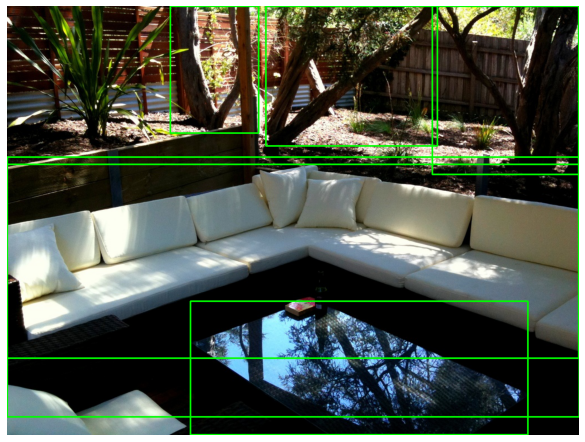

In [77]:
img_shape = img.shape[:2]

plt.figure(figsize=(img_shape[0]/75,img_shape[1]/75))
plt.axis('off')
plt.imshow(img);

Even though we picked images from selected classes those images also contains bounding boxes for objects that don't belong to subset classes.  

###  prepare the Dataset 

Register our dataset to detectron2, following the [detectron2 custom dataset tutorial.](https://detectron2.readthedocs.io/tutorials/datasets.html)

Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. See the tutorial for more details.

### Try Detecron 2 on Custom Dataset

Before jumping onto model building, try it on small dataset (probaly on single) and make sure it is working as expected 

In [61]:
!pwd

/home/santhosh/HardDisk/skumar/DataScience/Projects_Section/Projects_Working/Airbnb_Amenity_Detection/DataSets


In [8]:
#Coffee maker class as example 

train_path, valid_path = 'train/Coffeemaker', 'validation/Coffeemaker'


In [17]:
 MetadataCatalog.get??

In [9]:
from detectron2.data import DatasetCatalog, MetadataCatalog
for d in [valid_path, train_path]:
    print("Registering: {}".format(d.split("/")[-1]))
    #DatasetCatalog.register(d.split("/")[-1], lambda d=d: get_image_dicts(d))
    DatasetCatalog.register(d, lambda d=d: get_image_dicts(d))
    MetadataCatalog.get(d).set(thing_classes=["Coffeemaker"])
coffee_metadata = MetadataCatalog.get(valid_path)

Registering: Coffeemaker
Registering: Coffeemaker


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:

Using validation for annotations...
On dataset: validation
Classes we're using: Coffeemaker    18
Name: ClassName, dtype: int64
{'file_name': 'validation/Coffeemaker/d9149921780cc18a.jpg', 'image_id': 9, 'height': 683, 'width': 1024, 'annotations': [{'bbox': [56.885246, 1.021768, 1023.17975, 682.80396], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}]}


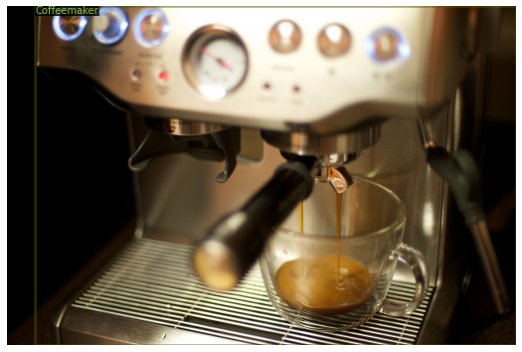

In [24]:
val_img_dicts = get_image_dicts(valid_path)

for d in random.sample(val_img_dicts, 1):
    print(d)
    img = cv2.imread(d["file_name"])
    
    img_shape = img.shape[:2]
    
    plt.figure(figsize=(img_shape[0]/75,img_shape[1]/75))
    visualizer = Visualizer(img[:, :, ::-1], metadata=coffee_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image())#[:, :, ::-1])
    plt.axis('off');

In [17]:
cfg.SOLVER

CfgNode({'LR_SCHEDULER_NAME': 'WarmupMultiStepLR', 'MAX_ITER': 180000, 'BASE_LR': 0.000125, 'MOMENTUM': 0.9, 'NESTEROV': False, 'WEIGHT_DECAY': 0.0001, 'WEIGHT_DECAY_NORM': 0.0, 'GAMMA': 0.1, 'STEPS': (120000, 160000), 'WARMUP_FACTOR': 0.001, 'WARMUP_ITERS': 2000, 'WARMUP_METHOD': 'linear', 'CHECKPOINT_PERIOD': 5000, 'IMS_PER_BATCH': 2, 'REFERENCE_WORLD_SIZE': 0, 'BIAS_LR_FACTOR': 1.0, 'WEIGHT_DECAY_BIAS': 0.0001, 'CLIP_GRADIENTS': CfgNode({'ENABLED': False, 'CLIP_TYPE': 'value', 'CLIP_VALUE': 1.0, 'NORM_TYPE': 2.0})})

In [22]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = ('train/Coffeemaker',)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 500    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (coffeemaker)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[08/22 10:56:43 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Using train for annotations...
On dataset: train
Classes we're using: Coffeemaker    51
Name: ClassName, dtype: int64
[08/22 10:56:57 d2.data.build]: Removed 0 images with no usable annotations. 35 images left.
[08/22 10:56:57 d2.data.build]: Distribution of instances among all 1 categories:
|  category   | #instances   |
|:-----------:|:-------------|
| Coffeemaker | 51           |
|             |              |
[08/22 10:56:57 d2.data.common]: Serializing 35 elements to byte tensors and concatenating them all ...
[08/22 10:56:57 d2.data.common]: Serialized dataset takes 0.01 MiB
[08/22 10:56:57 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[08/22 10:56:57 d2.data.build]: Using training sampler TrainingSampler


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.


In [42]:
%debug

> <__array_function__ internals>(5)concatenate()

ipdb> l

ipdb> self._lst
*** NameError: name 'self' is not defined
ipdb> type(x)
*** NameError: name 'x' is not defined
ipdb> exit


In [23]:
trainer.train()

[08/22 10:57:25 d2.engine.train_loop]: Starting training from iteration 0
[08/22 10:57:36 d2.utils.events]:  eta: 0:03:44  iter: 19  total_loss: 1.153  loss_cls: 0.715  loss_box_reg: 0.366  loss_rpn_cls: 0.019  loss_rpn_loc: 0.015  time: 0.4823  data_time: 0.0283  lr: 0.000050  max_mem: 2753M
[08/22 10:57:45 d2.utils.events]:  eta: 0:03:34  iter: 39  total_loss: 0.973  loss_cls: 0.444  loss_box_reg: 0.464  loss_rpn_cls: 0.017  loss_rpn_loc: 0.017  time: 0.4811  data_time: 0.0030  lr: 0.000100  max_mem: 2773M
[08/22 10:57:48 d2.engine.hooks]: Overall training speed: 44 iterations in 0:00:21 (0.4891 s / it)
[08/22 10:57:48 d2.engine.hooks]: Total training time: 0:00:21 (0:00:00 on hooks)


KeyboardInterrupt: 

In [50]:
%load_ext tensorboard
%tensorboard --logdir output

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 24119), started 0:11:33 ago. (Use '!kill 24119' to kill it.)

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:

In [22]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set the testing threshold for this model
cfg.DATASETS.TEST = ("validation/Coffeemaker", )
predictor = DefaultPredictor(cfg)

In [27]:
with open("valid_images/valid_images_labels.json") as f_in:
    valid_dicts = json.load(f_in)

In [29]:
valid_dicts[1]

{'file_name': 'valid_images/19c26248636e3402.jpg',
 'image_id': 1,
 'height': 1024,
 'width': 693,
 'annotations': [{'bbox': [0.0, 0.0, 693.0, 1024.0],
   'bbox_mode': 0,
   'category_id': 18},
  {'bbox': [0.0, 302.0, 510.0, 820.0], 'bbox_mode': 0, 'category_id': 125}]}

In [23]:
predictor(cv2.imread("validation/Coffeemaker/182c1f2bfa4b4280.jpg"))

{'instances': Instances(num_instances=2, image_height=1024, image_width=768, fields=[pred_boxes: Boxes(tensor([[ 55.6917,   4.2963, 768.0000, 994.5801],
         [181.5000,  13.7716, 765.1937, 557.5939]], device='cuda:0')), scores: tensor([0.9988, 0.7543], device='cuda:0'), pred_classes: tensor([0, 0], device='cuda:0')])}

Using validation for annotations...
On dataset: validation
Classes we're using: Coffeemaker    18
Name: ClassName, dtype: int64
{'instances': Instances(num_instances=3, image_height=634, image_width=1024, fields=[pred_boxes: Boxes(tensor([[  42.5312,   39.2737,  503.6866,  591.7103],
        [ 634.0979,   27.3926, 1016.7039,  577.1144],
        [ 440.0367,  269.3791,  578.8600,  535.5128]], device='cuda:0')), scores: tensor([0.9897, 0.9706, 0.7834], device='cuda:0'), pred_classes: tensor([0, 0, 0], device='cuda:0')])}


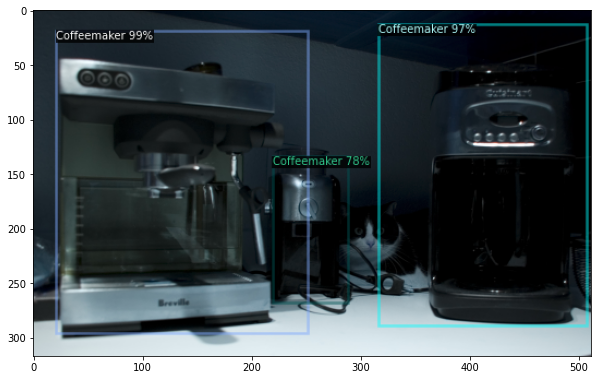

In [24]:
from detectron2.utils.visualizer import ColorMode


val_img_dicts = get_image_dicts(valid_path)

plt.figure(figsize=(10,10))
for d in random.sample(val_img_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(outputs)
    v = Visualizer(im[:, :, ::-1],
                   metadata=coffee_metadata, 
                   scale=0.5 
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1])

amazing!!

We can also evaluate its performance using AP metric implemented in COCO API. This gives an AP of ~70%. Not bad!

In [52]:
!pwd

/home/santhosh/HardDisk/skumar/DataScience/Projects_Section/Projects_Working/Airbnb_Amenity_Detection/DataSets


In [28]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("validation/Coffeemaker", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "validation/Coffeemaker")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

Using validation for annotations...
On dataset: validation
Classes we're using: Coffeemaker    18
Name: ClassName, dtype: int64
[08/18 14:24:04 d2.data.build]: Distribution of instances among all 1 categories:
|  category   | #instances   |
|:-----------:|:-------------|
| Coffeemaker | 18           |
|             |              |
[08/18 14:24:04 d2.data.common]: Serializing 17 elements to byte tensors and concatenating them all ...
[08/18 14:24:04 d2.data.common]: Serialized dataset takes 0.01 MiB
[08/18 14:24:04 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/18 14:24:04 d2.evaluation.evaluator]: Start inference on 17 images
[08/18 14:24:06 d2.evaluation.evaluator]: Inference done 11/17. 0.1270 s / img. ETA=0:00:00
[08/18 14:24:07 d2.evaluation.evaluator]: Total inference time: 0:00:01.512058 (0.126005 s / img per device, on 1 devices)
[08/18 14:24:07 d2.evaluation.evaluator]: Total

OrderedDict([('bbox',
              {'AP': 59.226363205057176,
               'AP50': 88.02453393929936,
               'AP75': 66.65597281180578,
               'APs': nan,
               'APm': nan,
               'APl': 59.226363205057176})])

Wow!! AP(Avg Precision) of 59 is pretty amazing compared to what airnb has achieved (around 50) .offcourse we only considered single class here

## Scale up model 

Its time to scale up our model to consider all the classes  

In [9]:
import logging
import os
from collections import OrderedDict
import torch
from torch.nn.parallel import DistributedDataParallel

import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2.config import get_cfg
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.engine import default_argument_parser, default_setup, launch
from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    inference_on_dataset,
    print_csv_format,
)
from detectron2.modeling import build_model
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.utils.events import (
    CommonMetricPrinter,
    EventStorage,
    JSONWriter,
    TensorboardXWriter,
)

# Setup logger
logger = logging.getLogger("detectron2")

In [10]:
# Different models I'd like to try - https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md
models = {
    "R50-FPN-1x": "COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml",
    "R50-FPN-3x": "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml",
    "R101-FPN-3x": "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml",
    "X101-FPN-3x": "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml",
    "RN-R50-1x": "COCO-Detection/retinanet_R_50_FPN_1x.yaml",
    "RN-R50-3x": "COCO-Detection/retinanet_R_50_FPN_3x.yaml",
    "RN-R101-3x": "COCO-Detection/retinanet_R_101_FPN_3x.yaml"
}

In [11]:
# Initialize Weights & Biases
import wandb # module for tracking model weights and biases 
wandb.init(project="airbnb-object-detection", 
           sync_tensorboard=True)

W&B Run: https://app.wandb.ai/skumarr53/airbnb-object-detection/runs/3aw9j9az

### Register Dataset

In [12]:
train_path, valid_path = 'train/Coffeemaker', 'validation/Coffeemaker'

In [13]:
from detectron2.data import DatasetCatalog, MetadataCatalog

In [17]:
## Generate JSON label file

_ = get_image_dicts('train/Coffeemaker',
                     'train-annotations-bbox.csv',['Coffeemaker'])

_ = get_image_dicts('validation/Coffeemaker',
                    'validation-annotations-bbox.csv',['Coffeemaker'])



Using train-annotations-bbox.csv for annotations...
On dataset: train
Classes we're using:
 Coffeemaker    51
Name: ClassName, dtype: int64
Total number of images: 35



Saving labels to: train/Coffeemaker/train_labels.json...
Using validation-annotations-bbox.csv for annotations...
On dataset: validation
Classes we're using:
 Coffeemaker    18
Name: ClassName, dtype: int64
Total number of images: 17



Saving labels to: validation/Coffeemaker/validation_labels.json...


In [14]:
def register_datasets(train_path, valid_path=None, target_cls=None):
    """
    Registers a Detectron2 style dataset from training paths.

    Params
    ------
    train_path (str) : pathname to training data containing training images
    valid_path (str) : pathname to validation data containing validation images
    """
    # TODO - update to accept any kind of path, e.g. not only coffeemaker, maybe could take a dict as input?
    # E.g. {"training": "path/to/training",
    #          "valid": "path/to/valid"}
    for d in [train_path, valid_path]:
        print("Registering: {}".format(d.split("/")[-1]))
        if d not in DatasetCatalog._REGISTERED.keys():
            DatasetCatalog.register(d, lambda d=d: load_json_labels(d))
        MetadataCatalog.get(d).set(thing_classes=target_cls)
    return MetadataCatalog.get(valid_path) # TODO - make this better

In [15]:
coffee_metadata = register_datasets(train_path=train_path,
                                    valid_path=valid_path,
                                   target_cls=['Coffeemaker'])

Registering: Coffeemaker
Registering: Coffeemaker


In [15]:
# Check registered dataset
DatasetCatalog._REGISTERED

{'coco_2014_train': <function detectron2.data.datasets.register_coco.register_coco_instances.<locals>.<lambda>()>,
 'coco_2014_val': <function detectron2.data.datasets.register_coco.register_coco_instances.<locals>.<lambda>()>,
 'coco_2014_minival': <function detectron2.data.datasets.register_coco.register_coco_instances.<locals>.<lambda>()>,
 'coco_2014_minival_100': <function detectron2.data.datasets.register_coco.register_coco_instances.<locals>.<lambda>()>,
 'coco_2014_valminusminival': <function detectron2.data.datasets.register_coco.register_coco_instances.<locals>.<lambda>()>,
 'coco_2017_train': <function detectron2.data.datasets.register_coco.register_coco_instances.<locals>.<lambda>()>,
 'coco_2017_val': <function detectron2.data.datasets.register_coco.register_coco_instances.<locals>.<lambda>()>,
 'coco_2017_test': <function detectron2.data.datasets.register_coco.register_coco_instances.<locals>.<lambda>()>,
 'coco_2017_test-dev': <function detectron2.data.datasets.register_

Using validation for annotations...
On dataset: validation
Classes we're using: Coffeemaker    18
Name: ClassName, dtype: int64
{'file_name': 'validation/Coffeemaker/182c1f2bfa4b4280.jpg', 'image_id': 11, 'height': 1024, 'width': 768, 'annotations': [{'bbox': [12.833281, 0.129024, 767.9662, 1024.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}]}


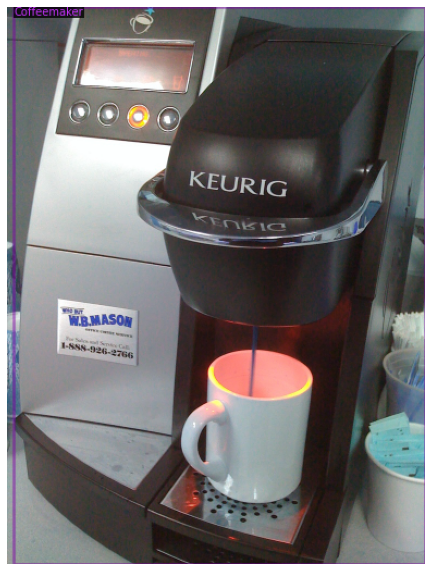

In [31]:
val_img_dicts = get_image_dicts(valid_path)

for d in random.sample(val_img_dicts, 1):
    print(d)
    
    img = cv2.imread(d["file_name"])
    img_shape = img.shape[:2]
    
    plt.figure(figsize=(img_shape[0]/75,img_shape[1]/75))
    visualizer = Visualizer(img[:, :, ::-1], metadata=coffee_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.axis('off')
    plt.imshow(vis.get_image()[:, :, ::-1]);

In [32]:
# Example use case of model_zoo
model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")

'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_1x/137257794/model_final_b275ba.pkl'

In [16]:
# Changed from original: Create evaluator for COCOEvaluator only
# Since we are only using bounding boxes to begin with, our evaluator can be simple COCO style
def get_evaluator(cfg, dataset_name, output_folder=None):
    """
    Create a COCOEvaluator
    """
    if output_folder is None:
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
    evaluator = COCOEvaluator(dataset_name=dataset_name,
                              cfg=cfg,
                              distributed=False,
                              output_dir=output_folder)
    set_trace()
    return evaluator


# Create testing function
def do_test(cfg, model):
    results = OrderedDict()
    for dataset_name in cfg.DATASETS.TEST:
        data_loader = build_detection_test_loader(cfg, dataset_name)
        # Create the evaluator
        evaluator = get_evaluator(cfg,
                                  dataset_name,
                                  output_folder=os.path.join(
                                      cfg.OUTPUT_DIR, "inference",
                                      dataset_name))
        # Make inference on dataset
        results_i = inference_on_dataset(model, data_loader, evaluator)
        # Update results dictionary
        results[dataset_name] = results_i

        print("### Returning results_i...")
        #print(results_i)
        #print(f"### Average Precision: {results_i['AP']}")
        # Let's get some communication happening
        if comm.is_main_process():
            logger.info("Evaluation results for {} in csv format:".format(
                dataset_name))
            ## wandb.log()? TODO/NOTE: This may be something Weights & Biases can track
            #print("### Calculating results...")
            print_csv_format(results_i)

        # Check to see length of results
        if len(results) == 1:
            results = list(results.values())[0]
        #print("### Returning results...")
        #print(results)

        # TODO : log results_i dict with different parameters
        print("### Saving results to Weights & Biases...")
        wandb.log(results_i)
        
    return results


# Create training function
def do_train(cfg, model, resume=False):
    # Set model to training mode
    model.train()
    # Create optimizer from config file (returns torch.nn.optimizer.Optimizer)
    optimizer = build_optimizer(cfg, model)
    # Create scheduler for learning rate (returns torch.optim.lr._LR_scheduler)
    scheduler = build_lr_scheduler(cfg, optimizer)
    print(f"Scheduler: {scheduler}")

    # Create checkpointer
    checkpointer = DetectionCheckpointer(model,
                                         save_dir=cfg.OUTPUT_DIR,
                                         optimizer=optimizer,
                                         scheduler=scheduler)

    # Create start iteration (refernces checkpointer) - https://detectron2.readthedocs.io/modules/checkpoint.html#detectron2.checkpoint.Checkpointer.resume_or_load
    start_iter = (
        # This can be 0
        checkpointer.resume_or_load(
            cfg.MODEL.
            WEIGHTS,  # Use predefined model weights (pretrained model)
            resume=resume).get("iteration", -1) + 1)
    # Set max number of iterations
    max_iter = cfg.SOLVER.MAX_ITER

    # Create periodiccheckpoint
    periodic_checkpointer = PeriodicCheckpointer(
        checkpointer=checkpointer,
        # How often to make checkpoints?
        period=cfg.SOLVER.CHECKPOINT_PERIOD,
        max_iter=max_iter)

    # Create writers (for saving checkpoints?)
    writers = ([
        # Print out common metrics such as iteration time, ETA, memory, all losses, learning rate
        CommonMetricPrinter(max_iter=max_iter),
        # Write scalars to a JSON file such as loss values, time and more
        JSONWriter(os.path.join(cfg.OUTPUT_DIR, "metrics.json")),
        # Write all scalars such as loss values to a TensorBoard file for easy visualization
        TensorboardXWriter(cfg.OUTPUT_DIR),
    ] if comm.is_main_process() else [])

    ### Original note from script: ###
    # compared to "train_net.py", we do not support accurate timing and precise BN
    # here, because they are not trivial to implement

    # Build a training data loader based off the training dataset name in the config
    data_loader = build_detection_train_loader(cfg)

    # Start logging
    logger.info("Starting training from iteration {}".format(start_iter))

    # Store events
    with EventStorage(start_iter) as storage:
        # Loop through zipped data loader and iteration
        for data, iteration in zip(data_loader, range(start_iter, max_iter)):
            iteration = iteration + 1
            storage.step(
            )  # update stroage with step - https://detectron2.readthedocs.io/modules/utils.html#detectron2.utils.events.EventStorage.step

            # Create loss dictionary by trying to model data
            loss_dict = model(data)
            losses = sum(loss_dict.values())
            # Are losses infinite? If so, something is wrong
            assert torch.isfinite(losses).all(), loss_dict

            # TODO - Not quite sure what's happening here
            loss_dict_reduced = {
                k: v.item()
                for k, v in comm.reduce_dict(loss_dict).items()
            }
            # Sum up losses
            losses_reduced = sum(loss for loss in loss_dict_reduced.values())

            # # TODO: wandb.log()? log the losses
            # wandb.log({
            #         "Total loss": losses_reduced
            # })

            # Update storage
            if comm.is_main_process():
                # Store informate in storage - https://detectron2.readthedocs.io/modules/utils.html#detectron2.utils.events.EventStorage.put_scalars
                storage.put_scalars(total_loss=losses_reduced,
                                    **loss_dict_reduced)

            # Start doing PyTorch things
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            # Add learning rate to storage information
            storage.put_scalar("lr",
                               optimizer.param_groups[0]["lr"],
                               smoothing_hint=False)
            # This is required for your learning rate to change!!!! (not having this meant my learning rate was staying at 0)
            scheduler.step()

            # Perform evaluation?
            if (cfg.TEST.EVAL_PERIOD > 0
                    and iteration % cfg.TEST.EVAL_PERIOD == 0
                    and iteration != max_iter):
                do_test(cfg, model)
                # TODO - compared to "train_net.py", the test results are not dumped to EventStorage
                comm.synchronize()

            # Log different metrics with writers
            if iteration - start_iter > 5 and (iteration % 20 == 0
                                               or iteration == max_iter):
                for writer in writers:
                    writer.write()

            # Update the periodic_checkpointer
            periodic_checkpointer.step(iteration)


# Create setup function
def setup(args):
    """
    Create configs and perform basic setups.
    """
    cfg = get_cfg()
    cfg.merge_from_file(
        args.config_file)  # This will take some kind of model.yaml file
    cfg.merge_from_list(args.opts)
    cfg.freeze()
    default_setup(
        cfg, args
    )  # this logs the config and arguments passed to the command line to the output file

    # Load config YAML as dict
    cfg_yaml = cfg.load_yaml_with_base(
        os.path.join(cfg.OUTPUT_DIR, "config.yaml"))

    # default_config = get_cfg()
    # default_config_loaded = default_config.load_yaml_with_base("output/config.yaml")
    # default_config_loaded

    # TODO: turn config into YAML and save to weights & biases
    # TODO: Init wandb and add configs
    # Setup a new weights & biases run every time we run the setup() function
    wandb.init(project="airbnb-object-detection", sync_tensorboard=True)

    #print("### Printing config_yaml file to go into Weights & Biases")
    #print(cfg_yaml)
    wandb.config.update(cfg_yaml)

    return cfg

# Create main function
def main(args):
    
    # Create the config file
    cfg = setup(args)

    # Build the model
    model = build_model(cfg)
    
    # Log what's going on
    logger.info("Model:\n{}".format(model))

    # TODO: Fix this (if it doesn't work)
    #wandb.watch(model, log="all")

    # Only do evaluation if the args say so
    if args.eval_only:
        DetectionCheckpointer(model, save_dir=cfg.OUTPUT_DIR).resume_or_load(
                cfg.MODEL.WEIGHTS, resume=args.resume
        )
        return do_test(cfg, model)

    # Do distributed training? (depends on number of GPUs available)
    distributed = comm.get_world_size() > 1
    if distributed:
        # Put the model on multiple devices if available
        model = DistributedDataParallel(
                model, 
                device_ids=[comm.get_local_rank()], 
                broadcast_buffers=False
        )

    # Train the model
    do_train(cfg, model)
    # TODO - May want to evaluate in a different step?
    return do_test(cfg, model)

In [36]:
models

{'R50-FPN-1x': 'COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml',
 'R50-FPN-3x': 'COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml',
 'R101-FPN-3x': 'COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml',
 'X101-FPN-3x': 'COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml',
 'RN-R50-1x': 'COCO-Detection/retinanet_R_50_FPN_1x.yaml',
 'RN-R50-3x': 'COCO-Detection/retinanet_R_50_FPN_3x.yaml',
 'RN-R101-3x': 'COCO-Detection/retinanet_R_101_FPN_3x.yaml'}

In [17]:
# Setup different weights and config files to try
weights = []
configs = []
for k, v in models.items():
    model = models[k]
    model_weights = model_zoo.get_checkpoint_url(model)
    weights.append(model_weights)
    config_file = model_zoo.get_config_file(model)
    configs.append(config_file)
    weights_configs = dict(zip(weights, configs))
weights_configs

{'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_1x/137257794/model_final_b275ba.pkl': '/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml',
 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl': '/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml',
 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl': '/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml',
 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl': '/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/detectron2/model_zoo/configs/C

In [38]:
train_path

'train/Coffeemaker'

In [18]:
# Setup different arg strings to pass to main() 
workers = 1
ims_per_batch = 1                    # lower memory issues 
lr = 0.00025
max_iter = 3000
seed = 33                            # for reproducibility
num_classes = 1

arg_strings = []
for weights, config in weights_configs.items(): # try out diff models
    arg_string = f"--config-file {config} \
                MODEL.WEIGHTS {weights} \
                DATASETS.TRAIN ('train/Coffeemaker',) \
                DATASETS.TEST ('validation/Coffeemaker',) \
                DATALOADER.NUM_WORKERS {workers} \
                SOLVER.IMS_PER_BATCH {ims_per_batch} \
                SOLVER.BASE_LR {lr} \
                SOLVER.MAX_ITER {max_iter} \
                SEED {seed} \
                MODEL.ROI_HEADS.NUM_CLASSES {num_classes}".split()
    arg_strings.append(arg_string)

In [23]:
len(arg_strings)

7

In [19]:
parser = default_argument_parser()


# Create different arg parsers
arg_list = []
for arg_string in arg_strings:
    args = parser.parse_args(arg_string)
    arg_list.append(args)

In [20]:
from modules.train import *

for i,arg in enumerate(arg_list):
    print(f">>>>>>>>>>>>> Running experiment: {i}")
    main(arg)

>>>>>>>>>>>>> Running experiment: 0
[08/23 13:42:22 detectron2]: Rank of current process: 0. World size: 1
[08/23 13:42:22 detectron2]: Rank of current process: 0. World size: 1
[08/23 13:42:22 detectron2]: Environment info:
----------------------  -------------------------------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.3 | packaged by conda-forge | (default, Jun  1 2020, 17:43:00) [GCC 7.5.0]
numpy                   1.19.1
detectron2              0.2.1 @/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 10.0
detectron2 arch flags   /home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/detectron2/_C.cpython-38-x86_64-linux-gnu.so
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.4.0+cu100 @/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/torch
PyTorch debug build     Fals

[08/23 13:42:22 detectron2]: Running with full config:
CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 1
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('validation/Coffeemaker',)
  TRAIN: ('train/Coffeemaker',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    F

[08/23 13:42:22 detectron2]: Full config saved to ./output/config.yaml
[08/23 13:42:22 detectron2]: Full config saved to ./output/config.yaml


### Printing config_yaml file to go into Weights & Biases
{'CUDNN_BENCHMARK': False, 'DATALOADER': {'ASPECT_RATIO_GROUPING': True, 'FILTER_EMPTY_ANNOTATIONS': True, 'NUM_WORKERS': 1, 'REPEAT_THRESHOLD': 0.0, 'SAMPLER_TRAIN': 'TrainingSampler'}, 'DATASETS': {'PRECOMPUTED_PROPOSAL_TOPK_TEST': 1000, 'PRECOMPUTED_PROPOSAL_TOPK_TRAIN': 2000, 'PROPOSAL_FILES_TEST': [], 'PROPOSAL_FILES_TRAIN': [], 'TEST': ['validation/Coffeemaker'], 'TRAIN': ['train/Coffeemaker']}, 'GLOBAL': {'HACK': 1.0}, 'INPUT': {'CROP': {'ENABLED': False, 'SIZE': [0.9, 0.9], 'TYPE': 'relative_range'}, 'FORMAT': 'BGR', 'MASK_FORMAT': 'polygon', 'MAX_SIZE_TEST': 1333, 'MAX_SIZE_TRAIN': 1333, 'MIN_SIZE_TEST': 800, 'MIN_SIZE_TRAIN': [640, 672, 704, 736, 768, 800], 'MIN_SIZE_TRAIN_SAMPLING': 'choice'}, 'MODEL': {'ANCHOR_GENERATOR': {'ANGLES': [[-90, 0, 90]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'NAME': 'DefaultAnchorGenerator', 'OFFSET': 0.0, 'SIZES': [[32], [64], [128], [256], [512]]}, 'BACKBONE': {'FREEZE_AT': 2, 'NAME': 'bui

[08/23 13:42:27 detectron2]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequ

[08/23 13:42:27 fvcore.common.checkpoint]: Loading checkpoint from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_1x/137257794/model_final_b275ba.pkl
[08/23 13:42:27 fvcore.common.file_io]: URL https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_1x/137257794/model_final_b275ba.pkl cached in /home/santhosh/.torch/fvcore_cache/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_1x/137257794/model_final_b275ba.pkl
[08/23 13:42:27 fvcore.common.checkpoint]: Reading a file from 'Detectron2 Model Zoo'
WARNING [08/23 13:42:27 fvcore.common.checkpoint]: Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
WARNING [08/23 13:42:27 fvcore.common.checkpoint]: Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint 

BdbQuit: 

In [ ]:
%debug

> /home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/detectron2/structures/instances.py(143)__iter__()
    141         raise NotImplementedError("Empty Instances does not support __len__!")
    142 
--> 143     def __iter__(self):
    144         set_trace()
    145         raise NotImplementedError("`Instances` object is not iterable!")

ipdb> type(self)
<class 'detectron2.structures.instances.Instances'>
